# Frequentist intervals

In lectures we learned a construction of frequentist intervals (the Neyman construction) that is designed to acheive a good coverage. In this notebook, we're going to apply this method to our simple counting experiment and calculate a frequentist interval, and calculate  the coverage of the intervals. We'll also compare to the interval one would get from applying Wilks' theorem. 

## Neyman intervals with profiled likelihood

We'll start with the Neyman construction for our interval. In this case, we'll calculate a 68% interval (commonly refered to as a 1$\sigma$ interval).

First, let's define our counting experiment model. 

In [1]:
%matplotlib inline

import numpy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rcParams.update({'font.size': 12})

# define the model for the counting experiment
sigma_TH = 0.01
A   = 0.5
eff = 0.9
l   = 100.
k   = 0.1
n   = 2

# Poisson mean
def lamb(mu,eta):
  return mu*eff*A*l*((1+k)**eta)*sigma_TH

We need to define our test-statistic. We will use the one based on the profiled likelihood ratio, i.e 

$$
\zeta_{\mu} = q(\mu,\eta_{\mu}) - q(\hat{\mu},\hat{\eta})
$$
if $\hat{\mu}\geq 0$ or, 
$$
\zeta_{\mu} = q(\mu,\eta_{\mu}) - q(0,\eta_{0})
$$
otherwise.

We can define each of these terms as functions to help us keep track.  

In [2]:
# define q, and q unconstrained and constrained functions
def q(mu,eta,np,eta_p):
  la = lamb(mu,eta)
  if np==0: return (eta-eta_p)*(eta-eta_p) + 2*la
  elif la<=0: return 99999
  else: return (eta-eta_p)*(eta-eta_p) + 2*la -2*np*numpy.log(la)

def q_unconstrained(x, args):
  mu, eta = x[0], x[1]
  np, eta_p = args[0], args[1]
  return q(mu,eta,np,eta_p)

def q_constrained(x, args):
  eta=x[0]
  mu, np, eta_p = args[0], args[1], args[2]
  return q(mu,eta,np,eta_p)

And some functions to find the profiled values of $\mu$ and $\eta$. 

In [3]:
# define the minimisation routines
def profiled_eta(mu, np, eta_p):
  init_params = [-3.0]
  bounds = [(-5,5)]
  res = minimize(q_constrained,init_params,args=[mu,np,eta_p],bounds=bounds)
  return res.x[0]

def global_min(np,eta_p):
  init_params = [0.1,-3.]
  bounds = [(-1,50),(-5,5)]
  mle = minimize(q_unconstrained,init_params,args=[np,eta_p],bounds=bounds)
  return mle.fun,mle.x[0]


Finally, we have all of the pieces to define our test-statistic.

In [4]:
# calculate test statistic
@numpy.vectorize
def zetamu(np,eta_p,mu):
  q_value        = q(mu,profiled_eta(mu,np,eta_p),np,eta_p)
  q_min,mu_min   = global_min(np,eta_p)
  if mu_min < 0     : return q_value-q(0,profiled_eta(0,np,eta_p),np,eta_p)
  else              : return q_value-q_min

Remember, we want to know, for each value of our parameter of interest ($\mu$), the part of the test-statistic distribution that contains 68% of possible outcomes of the test-statistic. 

For our test-statistic, this is the same as finding a single value of the test-statistic (call it $\zeta_{68}$) for which 68% of  $\zeta$ values are below. Remember, this is specified for each value of $\mu$. We'll define a function to generate toys so that we can determine the distribution of $\zeta$ and  $\zeta_{68}$. 

Notice that our toys consist of pairs of observations. One  is a random value of the observed  number of events $n$, and the other is a *observed* value of $\eta^{\prime}$. Usually this value is taken to be 0 but since it is too a random variable, it has a distribution. In HEP, we typically think of this as representing other measurements that we could have made for the parameter $\eta$. 

We need to choose a pdf to generate these $\eta^{\prime}$ from. Of course it should be a normal distribution as that is the term in the likelihood. We need a central value for this normal distribution and the usual convention is to use the profiled value of $\eta=\eta_{mu}$ - i.e it will be a different value for each $\mu$.  

In [5]:
# return a set of heights for each true value of mu
# for each value, we would mark on where 68% of the distribution lives
def histo_zetamu(mu):
  # find the best (profiled) nuisance parameter values for the data (n,0)
  eta_profiled = profiled_eta(mu,n,0)
  ntoys = 1000
  toy_n   = numpy.random.poisson(lamb(mu,eta_profiled),size=ntoys)
  toy_eta = numpy.random.normal(eta_profiled,1,size=ntoys)
  zetamu_dist = zetamu(toy_n,toy_eta,mu)
  #zetamu_dist = [zetamu(np,eta_p,mu) for np,eta_p in zip(toy_n,toy_eta)]
  zetamu_dist.sort() ; zeta_68 = zetamu_dist[int(ntoys*0.68)]
  return zetamu_dist, zeta_68

Let's look at the distribution for a single  value of $\mu=2$. We'll print out the value of $\zeta_{68}$ and the  value of  $\zeta$ using the observed values of $n=2$ and $\eta^{\prime}=0$ 

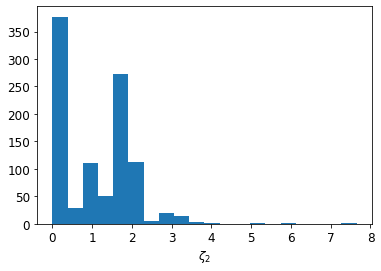

zeta_68= 1.7381200385701283
zeta_obs= 0.9831285358259025


In [6]:
zeta_obs_2 = zetamu(n,0,2)

distribution_2, zeta_68_2 =  histo_zetamu(2)
plt.hist(distribution_2,bins=20)
plt.xlabel("$\zeta_{2}$")
plt.show()

print("zeta_68=",zeta_68_2)
print("zeta_obs=",zeta_obs_2)

In this case, the observed value `zeta_obs` is less  than `zeta_68`. This means that the observed value is contained in the part of the distribution that contains 68% of the outcome! So we would accept this point ($\mu=2$) into our 68% interval. 

Now let's repeat for a range of $\mu$ values and report the full interval (i.e the range of points we accept). Note that this takes a little while to run.

In [7]:
mu_range   = numpy.arange(0.1,10,0.2)
zeta_range = numpy.arange(0.1,10,0.2)
zeta_obs_vals = []
zeta_68_vals  = []
mu_interval = []
densities = []

for mu_test in mu_range:
  zeta_obs = zetamu(n,0,mu_test)
  zetamu_toys,zeta_68 = histo_zetamu(mu_test)

  # we're also keeping a record of all the distributions
  density_vals = plt.hist(zetamu_toys,density=True,bins=zeta_range)
  densities.append(density_vals[0])

  zeta_68_vals.append(zeta_68)
  zeta_obs_vals.append(zeta_obs)
  if zeta_obs < zeta_68 : mu_interval.append(mu_test)

plt.clf()
# Print out the results
mu_l, mu_u = min(mu_interval),max(mu_interval)
mu_hat = global_min(n,0)[1]
print("interval -> (%.2f,%.2f)"%(mu_l,mu_u),", mu = %.2f + %.2f -%.2f "%(mu_hat,mu_u-mu_hat,mu_hat-mu_l))


interval -> (1.70,8.50) , mu = 4.44 + 4.06 -2.74 


<Figure size 432x288 with 0 Axes>

We can plot the distribution of $\zeta_{\mu}$ for each of our $\mu$ values that we tested. The colour map below shows the density of our test-statistic disribution. We also can overlay the values of $\zeta_{68}$ that we determined. 

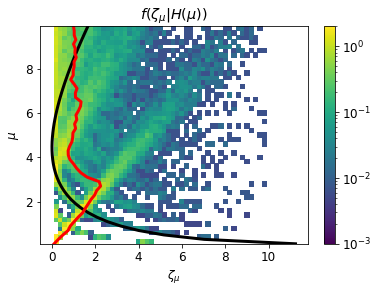

<Figure size 432x288 with 0 Axes>

In [8]:
X,Y = numpy.meshgrid(zeta_range,mu_range)
c = plt.pcolor(X,Y,densities, \
    norm=LogNorm(vmin=0.001, vmax=2.0))
plt.colorbar(c)
plt.plot(zeta_obs_vals,mu_range,color='black',linewidth=3)
plt.plot(zeta_68_vals,mu_range,color='red',linewidth=3)
plt.xlabel("$\zeta_{\mu}$")
plt.ylabel("$\\mu$")
plt.title("$f(\zeta_{\mu}|H(\mu))$")
plt.show()
plt.savefig("frequentist_interval.pdf")

You can see some odd structures here at small values of $\mu$, that seem to smooth out at larger values. Also the value of  $\zeta_{68}$ seems to settle down at larger values. This will be important for our next topic on coverage and Wilks'  theorem. 

## Coverage

We can check what the coverage of our methods (say for the 68.3\% interval) by determining the *fraction of intervals* in $\mu$, as a function of the true value $\mu_0$, that contain $\mu_{0}$. 

It sounds like a rather painful ordeal given that calculating a single interval can take time, however, we do not need to calculate each interval to figure out the coverage. 

Remember that $\mu$ is included in the interval provided $\zeta^{\mathrm{obs}}_{\mu}\leq\zeta^{68.3}_{\mu}$. For the Neyman construction, we can use toys to calculate $\zeta^{68.3}_{\mu}$, while for the MINOS method, we assume $\zeta^{68.3}_{\mu}=1$.

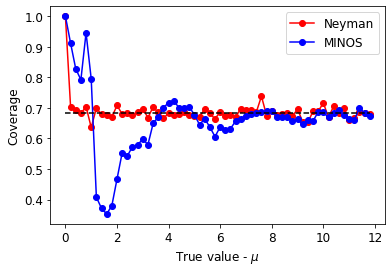

<Figure size 432x288 with 0 Axes>

In [9]:
def get_t683_neyman(mu):
  eta_profiled = (profiled_eta(mu,n,0))
  ntoys = 1000
  toy_n   = numpy.random.poisson(lamb(mu,eta_profiled),size=ntoys)
  toy_eta = numpy.random.normal(eta_profiled,1,size=ntoys)
  zetamu_dist = numpy.array([zetamu(np,eta_p,mu) for np,eta_p in zip(toy_n,toy_eta)])
  zetamu_dist.sort() ; zeta_68 = zetamu_dist[int(ntoys*0.683)]
  return zeta_68
    
mu_range   = numpy.arange(0,12,0.2)
n_coverage_toys = 1000

cov_Neyman, cov_MINOS = [], []
for mu_test in mu_range:
       # Generate from the profiled value of the nuisance parameter
       # we could also test the coverage under other values!
       eta_profiled = profiled_eta(mu_test,n,0)
       toy_n   = numpy.random.poisson(lamb(mu_test,eta_profiled),size=n_coverage_toys)
       toy_eta = numpy.random.normal(eta_profiled,1,size=n_coverage_toys)

       t683_Neyman = get_t683_neyman(mu_test)
       t683_MINOS  = 1
       zeta_obs_vals = numpy.array([ zetamu(np,eta_p,mu_test) for np,eta_p in zip(toy_n,toy_eta) ])
       coverage_Neyman = float(len([x for x in zeta_obs_vals if x <= t683_Neyman ]))/n_coverage_toys
       coverage_MINOS  = float(len([x for x in zeta_obs_vals if x <= t683_MINOS  ]))/n_coverage_toys
       cov_Neyman.append(coverage_Neyman)
       cov_MINOS.append(coverage_MINOS)

plt.plot(mu_range,cov_Neyman,color='red',marker="o",label="Neyman")
plt.plot(mu_range,cov_MINOS,color='blue',marker="o",label="MINOS")
plt.plot(mu_range,[0.683 for m in mu_range],color='black',linestyle="--")
plt.xlabel("True value - $\\mu$")
plt.ylabel("Coverage")
plt.legend()
plt.show()
plt.savefig("coverage_example.pdf")

You can see that the Neyman construction gives very close coverage to the desired 68.3\% except at very small $\mu$, where the discrete nature of the Poisson distribution makes it difficult to find the exact $\zeta^{68.3}_{\mu}$ - in fact this is still seen at larger values, though the effect gets reduced. Instead, the MINOS method, jumps between over-coverage and undercoverage, eventually settling down only above $\mu\sim 8$.

Below we plot the distribution of $\zeta_{\mu}$ at $\mu=0.1$ and $\mu=9$. For the larger value, away from the boundary the approximation of a $\chi^{2}(1)$ is much more accurate.

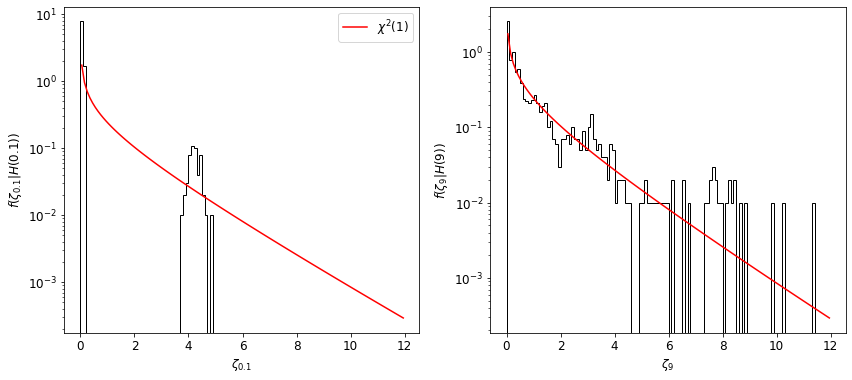

<Figure size 432x288 with 0 Axes>

In [11]:
from scipy.stats import chi2

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

chi2vals = chi2.pdf(numpy.arange(0.05,12.05,0.1),df=1)

ax1.hist(histo_zetamu(0.1)[0], \
    bins=numpy.arange(0,12,0.1),range=(0,12),\
    color='black',histtype='step',density=True)
ax1.plot(numpy.arange(0.05,12.05,0.1),chi2vals,color='red',label='$\chi^{2}(1)$')
ax2.hist(histo_zetamu(9)[0], \
    bins=numpy.arange(0,12,0.1),range=(0,12),\
    color='black',histtype='step',density=True)
ax2.plot(numpy.arange(0.05,12.05,0.1),chi2vals,color='red',label='$\chi^{2}(1)$')

ax1.set_xlabel("$\zeta_{0.1}$")
ax1.set_ylabel("$f(\zeta_{0.1}|H(0.1))$")
ax2.set_xlabel("$\zeta_{9}$")
ax2.set_ylabel("$f(\zeta_{9}|H(9))$")
ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.legend()
plt.show()
plt.savefig("tmu_dists_example.pdf")